In [3]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

In [5]:
%%bash
mkdir -p data write
cd data
test -f pbmc3k_filtered_gene_bc_matrices.tar.gz || curl https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o pbmc3k_filtered_gene_bc_matrices.tar.gz
tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

/Users/mac/apps/python/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==2.0.0 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==1.0.0 pynndescent==0.5.13


In [6]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

In [7]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... writing an h5ad cache file to speedup reading next time


In [10]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [14]:
adata.obs_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


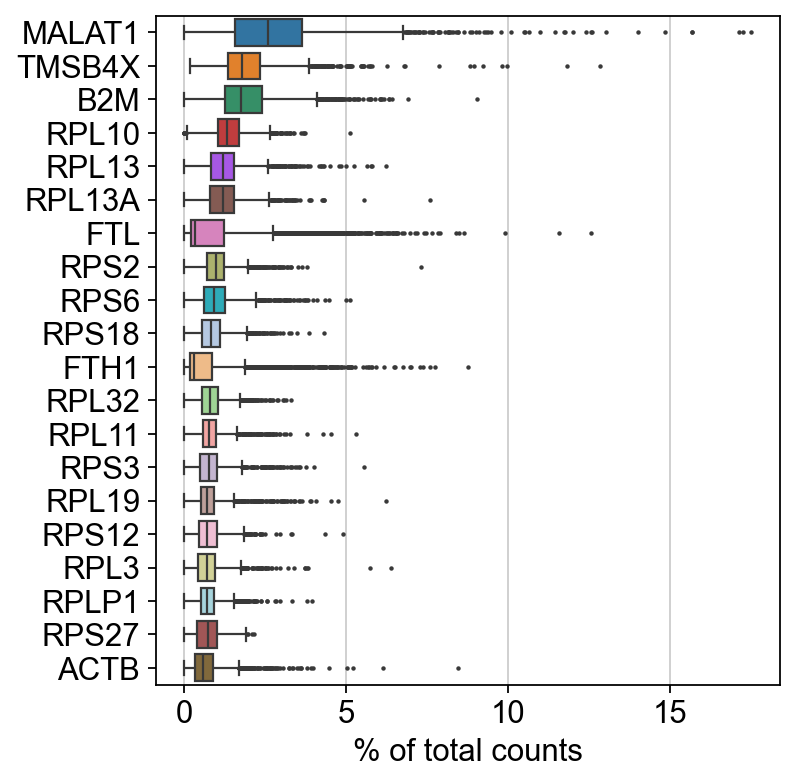

In [19]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [20]:
sc.pp.filter_cells(adata, min_genes=200)  # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [68]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795


In [39]:
adata.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0
...,...,...,...,...,...,...,...
AC145212.1,ENSG00000215750,16,False,16,0.006667,99.407407,18.0
AL592183.1,ENSG00000220023,323,False,323,0.134815,88.037037,364.0
AL354822.1,ENSG00000215615,8,False,8,0.002963,99.703704,8.0
PNRC2-1,ENSG00000215700,110,False,110,0.042963,95.925926,116.0


In [72]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)


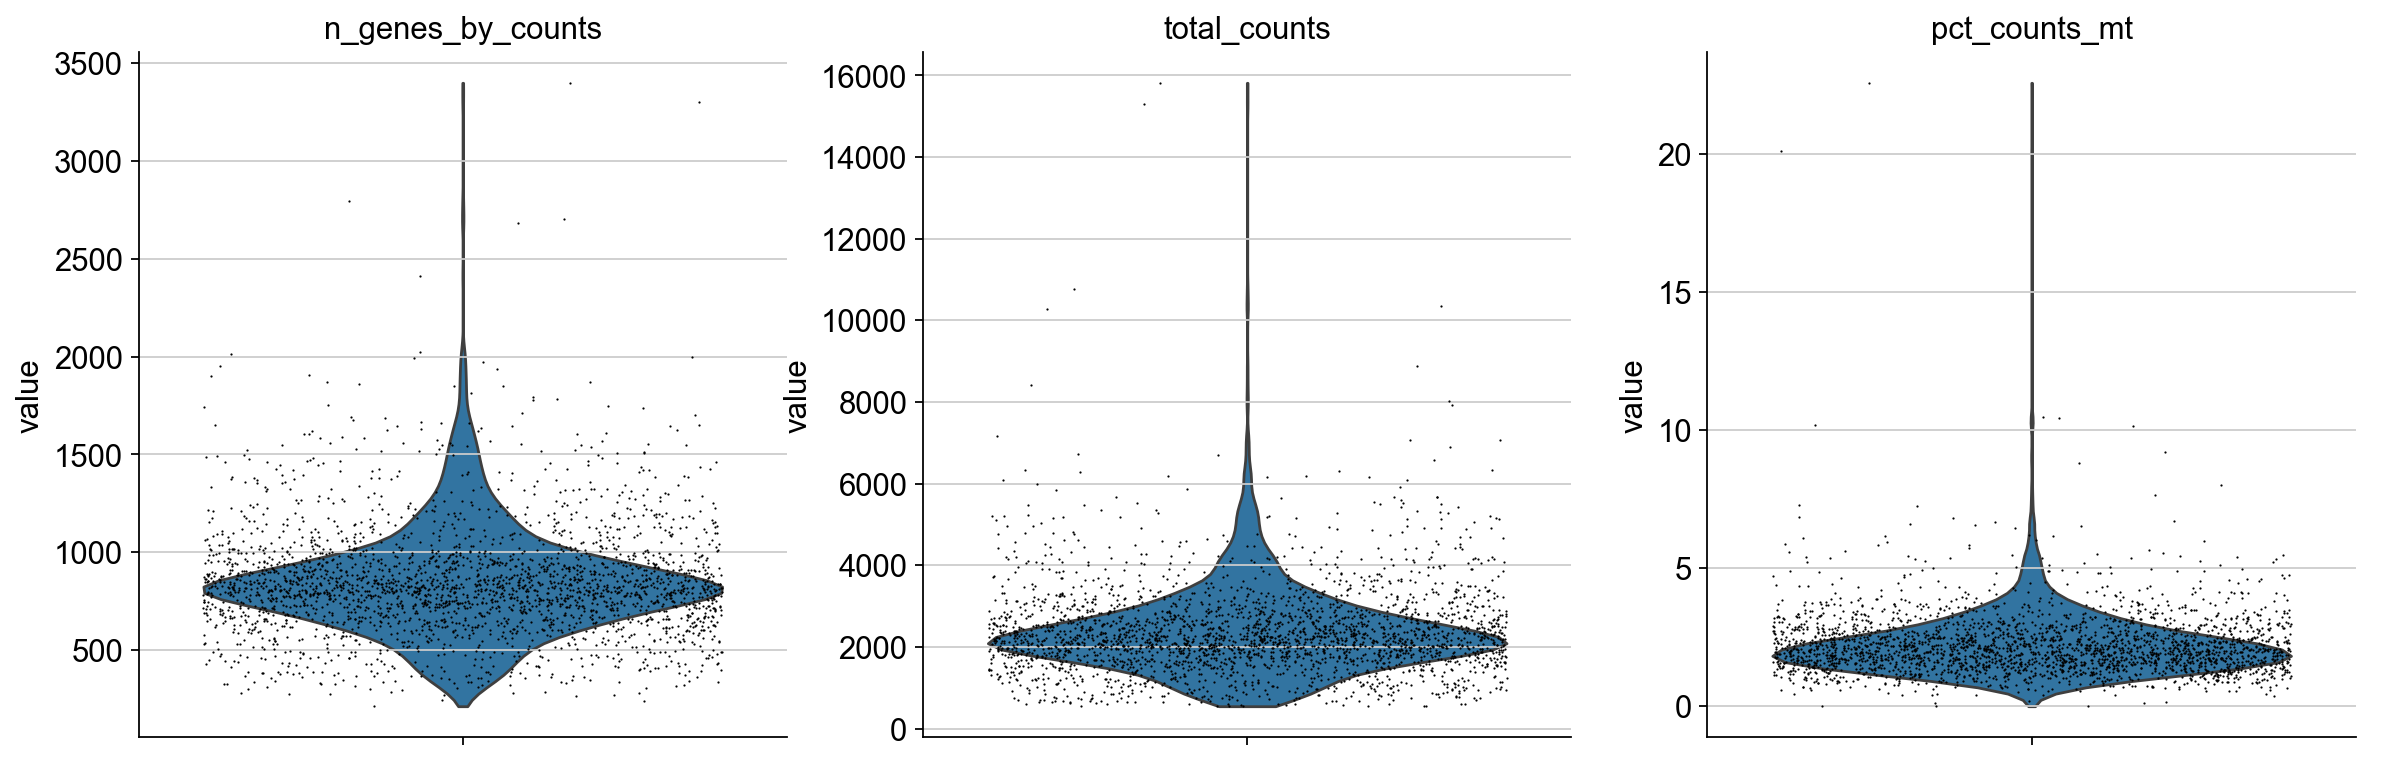

In [73]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [100]:
values = adata.var_names.values.copy()
values_dup = values[[0,3, 4]]

for i, v in enumerate(values_dup):
    print(i, v, type(v))

values_dup

0 AL627309.1 <class 'str'>
1 RP11-206L10.9 <class 'str'>
2 LINC00115 <class 'str'>


array(['AL627309.1', 'RP11-206L10.9', 'LINC00115'], dtype=object)

In [98]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)